<a href="https://colab.research.google.com/github/YooNayoung/ESAA/blob/main/0516session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **추천시스템 Collaborative Filtering - Model based approach**
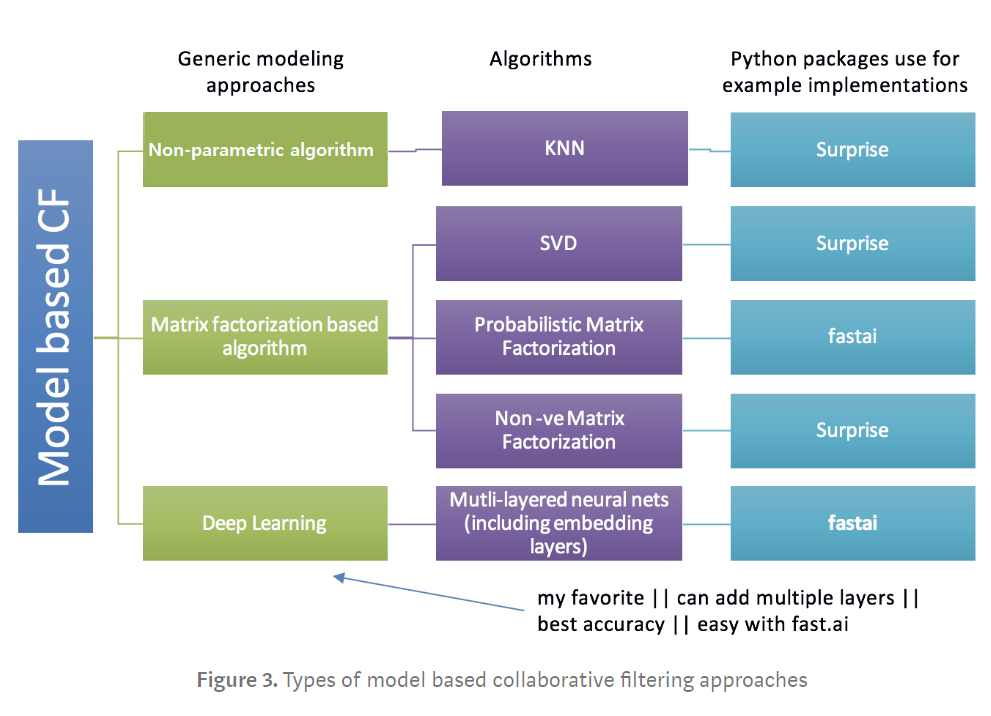


## **1. Matrix Factorization(MF)**
- 기본 아이디어는 "사용자의 선호도가 몇개의 hidden factors"로 결정될 수 있다는 것(이러한 factors들을 Embeddings이라 부른다.)
- Matrix decompoision은 loss function과 constraints에 대한 optimization으로 여겨질 수 있다. 
- constraints는 모델의 특성에 따라 선택되는데 예를 들어, Non-negative matrix decomposition는 resultant matrices가 non-negative 원소들을 갖기를 원하는 경우인데, 여기서는 non-negative 조건이 constraints가 된다.
- 위에서 언급한 Embeddings는 아이템과 사용자의 low dimensional hidden factors라 이해하면 된다.

## **2. Non-parametric approach(KNN)**
- Non-parametric approach의 아이디어는 memory-based 추천시스템의 아이디어와 같다. 
- Memory-based 알고리즘에서 우리는 예측을 하기 위해, 사용자간의 또는 아이템 간의 유사성을 weights로 사용한다.
- Non-parametric approach와의 차이는 메모리기반 방법에서의 유사성은 cosine, pearson유사도로 판단되는 것과 달리 Non-parametric approach에서는 unsupervised learning model을 사용한다는 것이다.
- 또한, Non-parametric approach는 유사한 사용자들의 수를 k와 같은 수로 한정지어 시스템을 더 확장가능하게 만든다.

## **3. Neural Nets / Deep Learning**
- neural nets을 이용하여 user latent features와 movie latent features를 업데이트해 최종 ratings를 구하는 것이 목적이다. 이로써 neural nets을 이용한 것은 matrix factorization의 확장판이라 생각할 수 있다.
- SVD나 PCA에서 우리는 우리의 original sparse 행렬을 두 개의 low rank orthogonal matrix로 분리하는데, neural net에서는 꼭 나눠진 matrix가 orthogonal일 필요가 없다. 우리는 그저 embedding matrices의 값들을 업데이트하는 것에 초점을 맞춘다. 
- User latent features와 Movie latent features는 후의 linear, non-linear layers의 input이 된다. 이러한 input은 relu, sigmoid layers에 넣어져 optimization방법에 따른 weights를 배우게 된다.

**Fast.ai 패키지**

In [ ]:
!pip3 install fastai
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [ ]:
!pip3 install spacy
!python -m spacy download en

In [ ]:
!pip3 install surprise

In [77]:
from surprise import Dataset
from surprise import Reader

In [32]:
class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)

1. Shallow Learning

In [3]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [30]:
path = "/content/drive/MyDrive/ESAA(OB)/"

In [ ]:
import pandas as pd
import numpy as np
ratings = pd.read_csv('/content/drive/MyDrive/ESAA(OB)/ratings_small.csv') # loading data from csv
"""
ratings_small.csv has 4 columns - userId, movieId, ratings, and timestammp
it is most generic data format for CF related data
"""

val_indx = get_cv_idxs(len(ratings))  # index for validation set
wd = 2e-4 # weight decay
n_factors = 50 # n_factors - dimension of embedding matrix (D)

# data loader
cf = CollabFilterDataset.from_csv(path, '/content/drive/MyDrive/ESAA(OB)/ratings_small.csv', 'userId', 'movieId', 'rating')

# learner initializes model object
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

# fitting model with 1e-2 learning rate, 2 epochs, 
# (1 cycle length and 2 cycle multiple for learning rate scheduling)
learn.fit(1e-2,2, wds = wd, cycle_len=1, cycle_mult=2)

2. Deep Learning


Step1>

fast.ai 라이브러리는 PyTorch에서 만들어졌기 때문에 data를 PyTorch data-loader로 로드한다.

여기서는 ColumnarModelData.from_data_frame을 사용하여 데이터셋을 로드했다.

In [37]:
x = ratings.drop([‘rating’],axis=1)
y = ratings[‘rating’].astype(np.float32)
data = ColumnarModelData.from_data_frame(path, val_indx, x, y, [‘userId’, ‘movieId’], 64)

SyntaxError: ignored

Step 2>

custom neural net을 정의한다.

초기화하는 함수 __init__()와 input값을 넣는 forward()가 필요하다.



In [ ]:
# nh = dimension of hidden linear layer
# p1 = dropout1
# p2 = dropout2

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, _n_movies, nh = 10, p1 = 0.05, p2= 0.5):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors),
            (n_users,1), (n_movies,1)
        ]]
        
        self.lin1 = nn.Linear(n_factors*2, nh)  # bias is True by default
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p = p1)
        self.drop2 = nn.Dropout(p = p2)
    
    def forward(self, cats, conts): # forward pass i.e.  dot product of vector from movie embedding matrixx
                                    # and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        
        users,movies = cats[:,0],cats[:,1]
        u2,m2 = self.u(users) , self.m(movies)
       
        x = self.drop1(torch.cat([u2,m2], 1)) # drop initialized weights
        x = self.drop2(F.relu(self.lin1(x))) # drop 1st linear + nonlinear wt
        r = F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating               
        return r

- dropout layer는 주어진 확률 parameter에 따라 activations을 떨어뜨리는 것이다. overfitting을 줄이기위해 랜덤으로 특정 액티베이션이 파라미터 업데이트에 참여하지 못하도록 하는 것이다.
- embedding layer는 unique 사용자들과 unique 영화들에 해당하는 embedding을 위해 lookup table을 만드는 것이다. back-propagation의 과정에서 값이 업데이트 된다. 이 부분은 좀 더 알아봐야 할 듯..
- linear는 bias를 추가하여 linear matrix multiplication을 하는 레이어다.
- relu는 relu function(f(x) = max(0,x)) 를 이용하여 non linearity를 추가하는 레이어다.
- sigmoid는 training data로부터 계산한 최소값과 최대값 사이의 평가값들을 제한하기 위함이다.(0부터 1사이의 값으로)

Step3>

In [ ]:
# n_users: count unique users (671), n_movies: count unique movies (9066)
model = EmbeddingNet(n_users, n_movies)

# model.parameters() for back-propagation of weights 
# lr = 1e-3, weight decay = 1e-5 and using adam optimizer 
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

# fitting model,
fit(model, data, 3, opt, F.mse_loss)

# learning rate annealing (for more, check links at the end)
set_lrs(opt, 1e-3)
fit(model, data, 3, opt, F.mse_loss)

# **Amazon Reviews를 이용한 추천시스템 실습 - surprise패키지 사용**

데이터 설명
- userId : 각 유저의 고유한 아이디
- productId : 각 상품의 고유한 아이디
- Rating : 각 유저가 각 상품에 대해 평가한 평점
- timestamp : 평가 시간 (본 알고리즘에서는 무시함)

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [40]:
electronics_data = pd.read_csv("/content/drive/MyDrive/ESAA(OB)/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [41]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [42]:
electronics_data.shape

(7824482, 4)

In [43]:
eletronics_data = electronics_data.iloc[:1048576,0:]

In [44]:
eletronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [45]:
eletronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [46]:
print("max of rating : %d" %(eletronics_data.Rating.max()))
print("min of rating : %d" %(eletronics_data.Rating.min()))

max of rating : 5
min of rating : 1


## **Missing values 수**

In [47]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


## **Ratings**

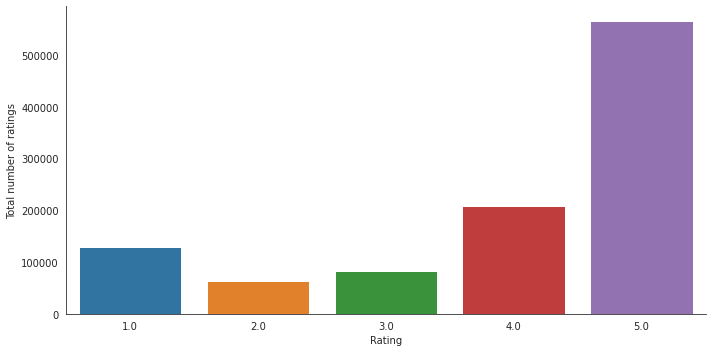

In [49]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data  = eletronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [50]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings :", eletronics_data.shape[0])
print("Total num of Users :", len(np.unique(eletronics_data.userId)))
print("Total num of products: ", len(np.unique(eletronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings : 1048576
Total num of Users : 786330
Total num of products:  61894


In [51]:
eletronics_data.drop(['timestamp'],axis = 1, inplace = True)

In [52]:
eletronics_data.head()

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


## **Ratings 분석**

In [53]:
num_of_rated_products_per_user = eletronics_data.groupby(by = 'userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [54]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [55]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [56]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

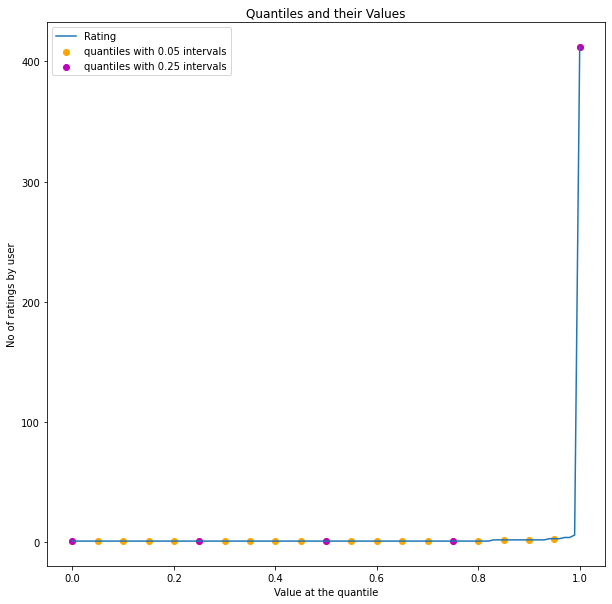

In [57]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [58]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(num_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



## **Popularity Based Recommendation**

In [59]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [60]:
new_df.head()

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [61]:
new_df.shape

(5374313, 4)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

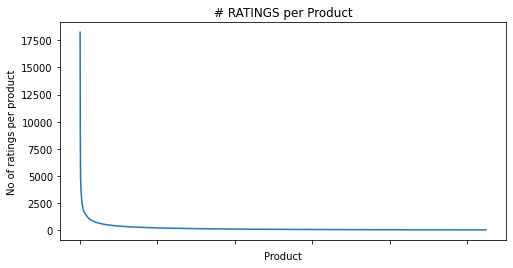

In [62]:
num_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [63]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [64]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

In [65]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [66]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [67]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [68]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [69]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [70]:
ratings_mean_count['rating_counts'].max()

18244

<Figure size 432x432 with 0 Axes>

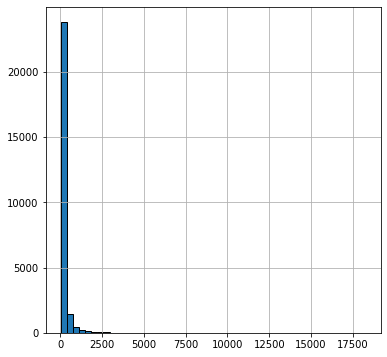

In [71]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

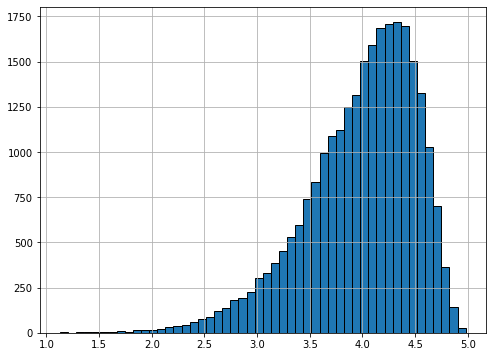

In [72]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

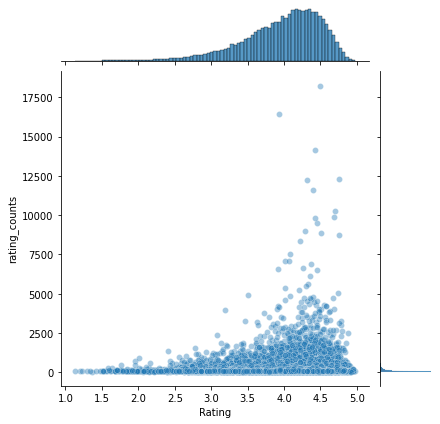

In [73]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

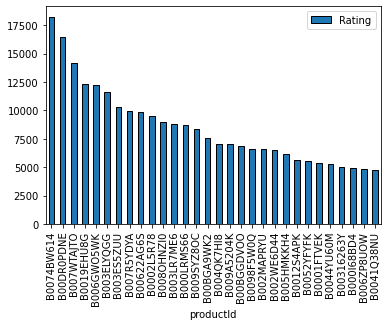

In [74]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind = "bar")